# Linear Regression

The workhorse of empirical research in the social sciences

In [1]:
import matplotlib as mpl
import pandas as pd
import pyrsm as rsm

# increase plot resolution
mpl.rcParams["figure.dpi"] = 150

from typing import List, Tuple

### Example 1: Catalog sales

We have access to data from a company selling men's and women's apparel through mail-order catalogs (dataset `catalog`). The company maintains a database on past and current customers' value and characteristics. Value is determined as the total \$ sales to the customer in the last year.

The catalog company is interested in redesigning their Customer Relationship Management (CRM) strategy. We will proceed in two steps:

1. Estimate a regression model using last year's sales total. Response variable: sales total for each of the 200 households; Explanatory variables: household income (measured in thousands of dollars), size of household, and age of the household head.

In [2]:
rsm.load_data(pkg="model", name="catalog", dct=globals())

In [3]:
rsm.describe(catalog)

## Catalog sales

### Description

Data from a company selling men's and women's apparel through mail-order catalogs. The company maintains a database on past and current customers' value and characteristics. Value is determine as the total $ sales to the customer in the last year. The data are a random sample of 200 customers from the company's database.

### Variables

A data frame with 200 observations on 4 variables

- id = Customer id
- Sales =	Total sales (in $) to a household in the past year
- Income = Household income ($1000) 
- HH.size = Size of the household (# of people) 
- Age = Age of the head of the household

In [4]:
import statsmodels.api as sm
import statsmodels

In [5]:
def estimate_model(data: pd.DataFrame, explanatory_vars: List[str], response_var: str) -> statsmodels.regression.linear_model.RegressionResults:
    """
    Estimate linear regression model

    Parameters
    ----------
    data: pandas dataframe; dataset
    explanatory_vars: list of strings; contains the names of the columns of data to be used as explanatory variables
    response_var: string; name of the column which is to be used as the response variable

    Returns
    -------
    res: Object with fitted values and residuals
    """

    explanatory_vars_df = data[explanatory_vars]
    explanatory_vars_df = sm.add_constant(explanatory_vars_df, prepend=False)

    model = sm.OLS(data[response_var], explanatory_vars_df)
    res = model.fit()

    data_name = ""
    if hasattr(data, "description"):
        data_name = data.description.split('\n')[0].split()[1].lower()

    print("Data:\t", data_name)
    print("Response variable:\t", response_var)
    print("Explanatory variables:\t", ", ".join(explanatory_vars))
    print(f"Null hyp.: the effect of x on {response_var} is zero")
    print(f"Alt. hyp.: the effect of x on {response_var} is not zero")
    summary = res.summary()
    summary.tables.pop()

    # print("================================================================")
    print("\n", summary)

    print("Sum of squares")
    index = ["Regression", "Error", "Total"]
    sum_of_squares = [res.ess, res.ssr, res.centered_tss]
    sum_of_squares_series = pd.Series(data=sum_of_squares, index=index)

    print("\n", sum_of_squares_series)

    return res

In [6]:
explanatory_vars = ["Income", "HH_size", "Age"]
response_var = "Sales"

In [7]:
fitted = estimate_model(catalog, explanatory_vars=explanatory_vars, response_var=response_var)

Data:	 catalog
Response variable:	 Sales
Explanatory variables:	 Income, HH_size, Age
Null hyp.: the effect of x on Sales is zero
Alt. hyp.: the effect of x on Sales is not zero

                             OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.331
Model:                            OLS   Adj. R-squared:                  0.321
Method:                 Least Squares   F-statistic:                     32.33
Date:                Thu, 12 May 2022   Prob (F-statistic):           5.08e-17
Time:                        16:51:21   Log-Likelihood:                -1179.8
No. Observations:                 200   AIC:                             2368.
Df Residuals:                     196   BIC:                             2381.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std e

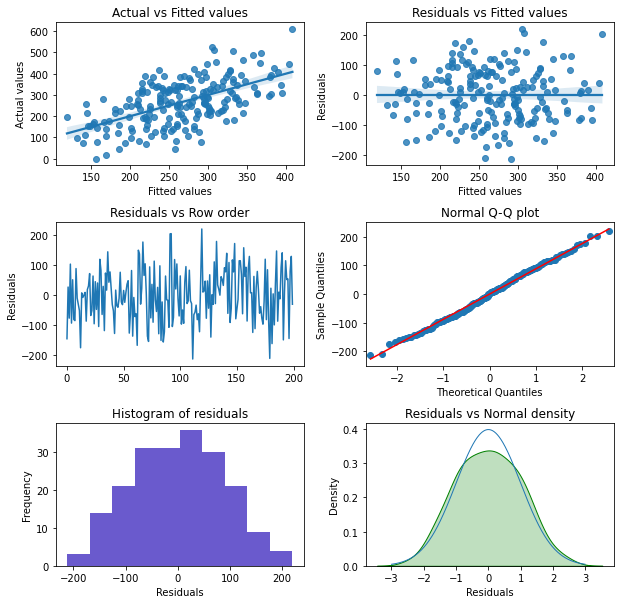

In [8]:
rsm.regression.reg_dashboard(fitted=fitted, nobs=-1)

In [9]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

In [10]:
class ProbabilityCalculator:
    def __init__(self, distribution) -> None:
        self.distribution = distribution
        print("Probability calculator")

    def calculate(self, **kwargs):
        print(f"Distribution: {self.distribution}")
        def calc_f_dist(dfn: int, dfd: int, lb: float=0, ub: float=0.95, decimals: int=3) -> Tuple[float, float]:
            print(f"Df 1:\t{dfn}")
            print(f"Df 2:\t{dfd}")

            print(f"Mean:\t{round(stats.f.mean(dfn, dfd, loc=lb), decimals)}")
            print(f"Variance:\t{round(stats.f.var(dfn, dfd, loc=lb), decimals)}")
            print(f"Lower bound:\t{lb}")
            print(f"Upper bound:\t{ub}")
            print()

            if lb == 0:
                critical_f = round(stats.f.ppf(q=ub, dfn=dfn, dfd=dfd), decimals)

                _num_decimal_places_in_ub = len(str(ub).split('.')[-1])

                print(f"P(X < {critical_f}) = {ub}")
                print(f"P(X > {critical_f}) = {round(1 - ub, _num_decimal_places_in_ub)}")
                return (0, critical_f)

            critical_f_lower = round(stats.f.ppf(q=lb, dfn=dfn, dfd=dfd), decimals)

            _num_decimal_places_in_lb = len(str(lb).split('.')[-1])

            print(f"P(X < {critical_f_lower}) = {lb}")
            print(f"P(X > {critical_f_lower}) = {round(1 - lb, _num_decimal_places_in_lb)}")
            ########################################################################################
            critical_f_upper = round(stats.f.ppf(q=ub, dfn=dfn, dfd=dfd), decimals)

            _num_decimal_places_in_ub = len(str(ub).split('.')[-1])

            print(f"P(X < {critical_f_upper}) = {ub}")
            print(f"P(X > {critical_f_upper}) = {round(1 - ub, _num_decimal_places_in_ub)}")
            ########################################################################################
            _num_decimal_places = max(len(str(ub).split('.')[-1]), len(str(lb).split('.')[-1]))

            print(f"P({critical_f_lower} < X < {critical_f_upper}) = {round((ub - lb), _num_decimal_places)}")
            print(f"1 - P({critical_f_lower} < X < {critical_f_upper} = {round(1 - (ub - lb), _num_decimal_places)}")

            return (critical_f_lower, critical_f_upper)

        def calc_t_dist(df: int, lb: float=0, ub: float=0.95, decimals: int=3) -> Tuple[float, float]:
            print(f"Df:\t{df}")
            print(f"Mean:\t{round(stats.t.mean(df), decimals)}")
            print(f"St. dev:\t{round(stats.t.std(df), decimals)}")
            print(f"Lower bound:\t{lb}")
            print(f"Upper bound:\t{ub}")
            print()

            if lb == 0:
                critical_t = round(stats.t.ppf(q=ub, df=df), decimals)

                _num_decimal_places_in_ub = len(str(ub).split('.')[-1])

                print(f"P(X < {critical_t}) = {ub}")
                print(f"P(X > {critical_t}) = {round(1 - ub, _num_decimal_places_in_ub)}")
                return (0, critical_t)

            critical_t_lower = round(stats.t.ppf(q=lb, df=df), decimals)

            _num_decimal_places_in_lb = len(str(lb).split('.')[-1])

            print(f"P(X < {critical_t_lower}) = {lb}")
            print(f"P(X > {critical_t_lower}) = {round(1 - lb, _num_decimal_places_in_lb)}")
            ########################################################################################
            critical_t_upper = round(stats.t.ppf(q=ub, df=df), decimals)

            _num_decimal_places_in_ub = len(str(ub).split('.')[-1])

            print(f"P(X < {critical_t_upper}) = {ub}")
            print(f"P(X > {critical_t_upper}) = {round(1 - ub, _num_decimal_places_in_ub)}")
            ########################################################################################
            _num_decimal_places = max(len(str(ub).split('.')[-1]), len(str(lb).split('.')[-1]))

            print(f"P({critical_t_lower} < X < {critical_t_upper}) = {round((ub - lb), _num_decimal_places)}")
            print(f"1 - P({critical_t_lower} < X < {critical_t_upper} = {round(1 - (ub - lb), _num_decimal_places)}")

            return (critical_t_lower, critical_t_upper)

        if self.distribution == "F":
            lb = kwargs["lb"] if "lb" in kwargs else 0
            ub = kwargs["ub"] if "ub" in kwargs else 0.95
            dfn = kwargs["dfn"]
            dfd = kwargs["dfd"]
            decimals = kwargs["decimals"] if "decimals" in kwargs else 3
            calc_f_dist(dfn, dfd, lb, ub, decimals)

        elif self.distribution == "t":
            lb = kwargs["lb"] if "lb" in kwargs else 0
            ub = kwargs["ub"] if "ub" in kwargs else 0.95
            df = kwargs["df"]
            decimals = kwargs["decimals"] if "decimals" in kwargs else 3
            calc_t_dist(df, lb, ub, decimals)

    def plot(self, **kwargs):
        def plot_f_dist(dfn: int, dfd: int, lb: float=0, ub:float=0.95, decimals: int=3):
            x = np.linspace(stats.f.ppf(0, dfn, dfd), stats.f.ppf(0.99, dfn, dfd), 200)

            plt.grid()
            pdf = stats.f.pdf(x, dfn, dfd)

            plt.plot(x, pdf, 'r-', lw=3, alpha=0.6, label='f pdf')

            if lb == 0:
                critical_f = round(stats.f.ppf(q=ub, dfn=dfn, dfd=dfd), decimals)
                plt.fill_between(x, pdf, where=(x > critical_f))
            else:
                critical_f_lower = round(stats.f.ppf(q=lb, dfn=dfn, dfd=dfd), decimals)
                critical_f_upper = round(stats.f.ppf(q=ub, dfn=dfn, dfd=dfd), decimals)

                plt.fill_between(x, pdf, where=((x > critical_f_upper) | (x < critical_f_lower)))

        def plot_t_dist(df: int, lb: float=0, ub: float=0.95, decimals: int=3):
            x = np.linspace(stats.t.ppf(0.01, df), stats.t.ppf(0.99, df), 200)

            plt.grid()
            pdf = stats.t.pdf(x, df)

            plt.plot(x, pdf, 'r-', lw=3, alpha=0.6, label='t pdf')

            if lb == 0:
                critical_t = round(stats.t.ppf(q=ub, df=df), decimals)
                plt.fill_between(x, pdf, where=(x > critical_t))
            else:
                critical_t_lower = round(stats.t.ppf(q=lb, df=df), decimals)
                critical_t_upper = round(stats.t.ppf(q=ub, df=df), decimals)

                plt.fill_between(x, pdf, where=((x > critical_t_upper) | (x < critical_t_lower)))

        if self.distribution == "F":
            lb = kwargs["lb"] if "lb" in kwargs else 0
            ub = kwargs["ub"] if "ub" in kwargs else 0.95
            dfn = kwargs["dfn"]
            dfd = kwargs["dfd"]
            decimals = kwargs["decimals"] if "decimals" in kwargs else 3
            plot_f_dist(dfn, dfd, lb, ub, decimals)

        elif self.distribution == "t":
            lb = kwargs["lb"] if "lb" in kwargs else 0
            ub = kwargs["ub"] if "ub" in kwargs else 0.95
            df = kwargs["df"]
            decimals = kwargs["decimals"] if "decimals" in kwargs else 3
            plot_t_dist(df, lb, ub, decimals)

Probability calculator
Distribution: F
Df 1:	3
Df 2:	196
Mean:	1.035
Variance:	0.698
Lower bound:	0.025
Upper bound:	0.975

P(X < 0.072) = 0.025
P(X > 0.072) = 0.975
P(X < 3.183) = 0.975
P(X > 3.183) = 0.025
P(0.072 < X < 3.183) = 0.95
1 - P(0.072 < X < 3.183 = 0.05


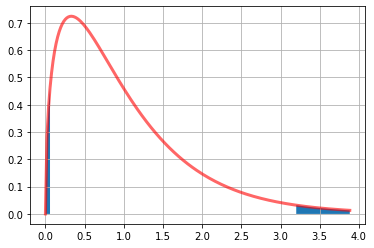

In [11]:
params = dict(zip(["dfn", "dfd", "lb", "ub", "decimals"], [3, 196, 0.025, 0.975, 3]))

prob_calc_f = ProbabilityCalculator(distribution="F")
prob_calc_f.calculate(**params)
prob_calc_f.plot(**params)

Probability calculator
Distribution: t
Df:	196
Mean:	0.0
St. dev:	1.005
Lower bound:	0.025
Upper bound:	0.975

P(X < -1.972) = 0.025
P(X > -1.972) = 0.975
P(X < 1.972) = 0.975
P(X > 1.972) = 0.025
P(-1.972 < X < 1.972) = 0.95
1 - P(-1.972 < X < 1.972 = 0.05


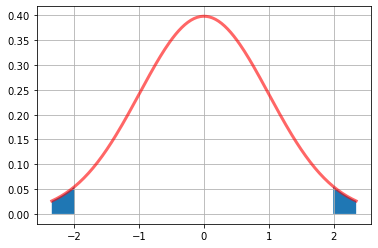

In [12]:
params = dict(zip(["df", "lb", "ub", "decimals"], [196, 0.025, 0.975, 3]))

prob_calc_t = ProbabilityCalculator(distribution="t")
prob_calc_t.calculate(**params)
prob_calc_t.plot(**params)

2. Interpret each of the estimated coefficients. Also provide a statistical evaluation of the model as a whole.